In [1]:
%load_ext tensorboard

In [2]:
import os
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.integrate import solve_ivp
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

from assets.ml.DeepONetwork import TrunkNN
from assets.ml.DeepONetwork import BranchNN
from assets.ml.DeepONetwork import DeepONET
from assets.ml.DeepONetwork import DeepOPINN
from assets.ml.DeepONetwork import LogPINNLossesCallback
from assets.ml.DeepONetwork import PredictOnEpochEndCallback

2023-12-26 17:36:32.148865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def createSamples(lengthScale, k, domain):
    kernel = RBF(length_scale=lengthScale)
    GP = GaussianProcessRegressor(kernel=kernel)
    u_sample = np.zeros((k, 100))
    for i in range(k):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = GP.sample_y(domain.reshape(-1, 1), random_state=n).flatten()

    return u_sample

In [4]:
def solutions(u, t):
    sols = []
    for i in tqdm(range(u.shape[0]), desc="Generating Solutions", ncols=90):
        sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), u[i, :]), t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
        sols.append(sol.y[0].reshape(-1, 1))

    return np.array(sols)

In [5]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RBF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    
    # Create random fields
    random_field = createSamples(length_scale, N, domain=np.linspace(0, 1, 100))
    
    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N), desc="Generating Data", ncols = 80):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]), 
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
        
    return X, y

In [6]:
# Create training dataset
N_train = 1000
length_scale_train = 0.5
X_train, y_train = generate_dataset(N_train, length_scale_train, ODE_solve=True)

# Create validation dataset
N_val = 500
length_scale_test = 0.3
X_val, y_val = generate_dataset(N_val, length_scale_test, ODE_solve=True)

# Create testing dataset
N_test = 500
length_scale_test = 0.2
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

Generating Data: 100%|███████████████████████| 500/500 [00:00<00:00, 523.92it/s]


In [7]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [8]:
train_index = np.random.choice(np.arange(0, N_train), size=1, replace=False)[0]
val_index = np.random.choice(np.arange(0, N_val), size=1, replace=False)[0]
test_index = np.random.choice(np.arange(0, N_test), size=1, replace=False)[0]

t_train_exp = X_train[train_index*100:(train_index + 1)*100, :1]
g_train_exp = X_train[train_index*100:(train_index + 1)*100, 1:-1]
gt_train_exp = X_train[train_index*100:(train_index + 1)*100, -1:]

sol_train = y_train[train_index*100:(train_index + 1)*100]

train_example = [g_train_exp, t_train_exp, gt_train_exp]

t_val_exp = X_val[val_index*100:(val_index + 1)*100, :1]
g_val_exp = X_val[val_index*100:(val_index + 1)*100, 1:-1]
gt_val_exp = X_val[val_index*100:(val_index + 1)*100, -1:]

sol_val = y_val[val_index*100:(val_index + 1)*100]

val_example = [g_val_exp, t_val_exp, gt_val_exp]

t_test_exp = X_test[test_index*100:(test_index + 1)*100, :1]
g_test_exp = X_test[test_index*100:(test_index + 1)*100, 1:-1]
gt_test_exp = X_test[test_index*100:(test_index + 1)*100, -1:]

sol_test = y_test[test_index*100:(test_index + 1)*100]

test_example = [g_test_exp, t_test_exp, gt_test_exp]

examples = [train_example, val_example, test_example]
sols = [sol_train, sol_val, sol_test]

In [9]:
# Restructure the trainging dataset
t_train = X_train[:, :1]
g_train = X_train[:, 1:-1]
gt_train = X_train[:, -1:]

X_train = [g_train, t_train, gt_train]

# Restructure the validation dataset
t_val = X_val[:, :1]
g_val = X_val[:, 1:-1]
gt_val = X_val[:, -1:]

X_val = [g_val, t_val, gt_val]

# Restructure the test dataset
t_test = X_test[:, :1]
g_test = X_test[:, 1:-1]
gt_test = X_test[:, -1:]

X_test = [g_test, t_test, gt_test]

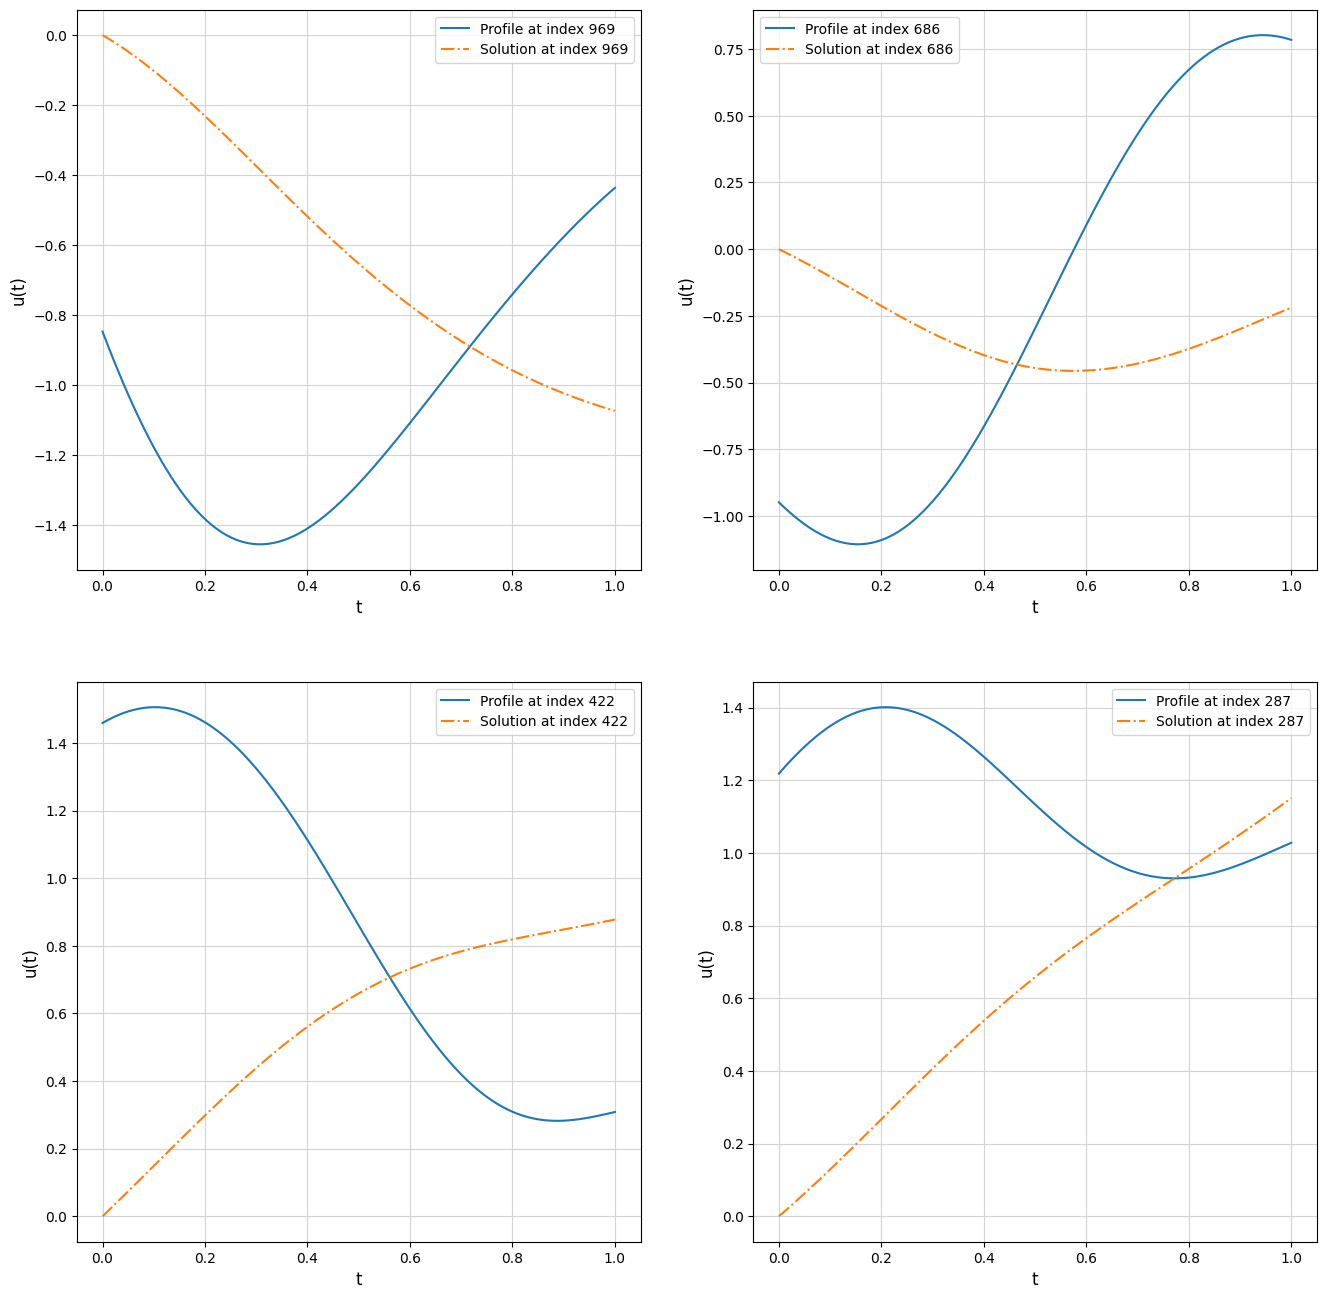

In [10]:
domain = np.linspace(0, 1, 100)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))

index = np.random.choice(np.arange(0, N_train), size=4, replace=False)

for i in range(4):
    ax = axs[i // 2][i % 2]
    ax.plot(domain, g_train[index[i]*100], label = f"Profile at index {index[i]}")
    ax.plot(domain, y_train[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [11]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"DeepONET_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch= '10, 110')

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

2023-12-26 17:36:49.092489: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-26 17:36:49.092511: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-12-26 17:36:49.092626: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [12]:
%tensorboard --logdir ./assets/logs --port=8081

In [13]:
modelPath = os.path.join(".", "assets", "ml", "DeepONET", "deepONET.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [14]:
predictionsCallback = PredictOnEpochEndCallback(examples=examples, solutions=sols)

In [15]:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=50, min_lr=1e-9)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback, predictionsCallback]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

In [16]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETDense_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETDense_layer{i+1}") for i in range(5)]


branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepONET = DeepONET(branchNN=branchNET, trunkNN=trunkNET)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepONET.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

In [18]:
deepONET.build(input_shape=[(None, 100), (None, 1)])

In [19]:
deepONET.summary()

Model: "deep_onet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 branch_nn (BranchNN)        multiple                  4120      
                                                                 
 trunk_nn (TrunkNN)          multiple                  2140      
                                                                 
 bias_layer (BiasLayer)      multiple                  1         
                                                                 
Total params: 6261 (24.46 KB)
Trainable params: 6261 (24.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
deepONET.fit(x=X_train, y=y_train, epochs=5000, verbose=False, batch_size=100, validation_data=(X_val, y_val), callbacks=_callbacks)

Epoch 1/10
  23/1000 [..............................] - ETA: 10s - loss: 0.0845 - mae: 0.2011 - mean_absolute_percentage_error: 371082.1875 - root_mean_squared_error: 0.2907

2023-12-26 17:37:00.910009: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-12-26 17:37:00.910036: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


 106/1000 [==>...........................] - ETA: 7s - loss: 0.0307 - mae: 0.1098 - mean_absolute_percentage_error: 652848.3750 - root_mean_squared_error: 0.1753

2023-12-26 17:37:01.799302: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


 115/1000 [==>...........................] - ETA: 27s - loss: 0.0290 - mae: 0.1061 - mean_absolute_percentage_error: 731247.3125 - root_mean_squared_error: 0.1702

2023-12-26 17:37:04.185965: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-12-26 17:37:04.188543: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./assets/logs/fits/DeepONET_20231226-173649/plugins/profile/2023_12_26_17_37_04/bmbp.modem.xplane.pb


4/4 [==============================] - 0s 3ms/step
(100,)
(100,)
(100,)
1000/1000 [==============================] - 16s 13ms/step - loss: 0.0082 - mae: 0.0597 - mean_absolute_percentage_error: 933364.9375 - root_mean_squared_error: 0.0906 - val_loss: 0.0071 - val_mae: 0.0608 - val_mean_absolute_percentage_error: 623208.3750 - val_root_mean_squared_error: 0.0844 - lr: 0.0010
Epoch 2/10
4/4 [==============================] - 0s 2ms/step
(100,)
(100,)
(100,)
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0012 - mae: 0.0243 - mean_absolute_percentage_error: 305015.2812 - root_mean_squared_error: 0.0341 - val_loss: 0.0079 - val_mae: 0.0658 - val_mean_absolute_percentage_error: 508799.2188 - val_root_mean_squared_error: 0.0890 - lr: 0.0010
Epoch 3/10
4/4 [==============================] - 0s 2ms/step
(100,)
(100,)
(100,)
1000/1000 [==============================] - 9s 9ms/step - loss: 8.5641e-04 - mae: 0.0209 - mean_absolute_percentage_error: 274708.4062 - root_mean_squa

In [ ]:
deepONET.load_weights(filepath=modelPath)

testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [ ]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [ ]:
pred_test = deepONET.predict(X_test)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
index = np.random.choice(np.arange(0, N_test), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(domain, g_test[index[i]*100], label = f"Profile at index {index[i]}")
    ax.plot(domain, y_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.plot(domain, pred_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Prediction at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [ ]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [ ]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [ ]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepONET.predict([testBranchInput, testTrunkInput])
print(preds.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [ ]:
branchOutput = deepONET.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepONET.trunkNN(testTrunkInput)
print(trunkOutput.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [ ]:
log_dir = os.path.join(".", "assets", "logs", "fits", f"DeepOPINN_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch=True, )

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [ ]:
modelPath = os.path.join(".", "assets", "ml", "DeepOPINN", "deepOPINN.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [ ]:
pinnCallback = LogPINNLossesCallback()
predictionsCallback = PredictOnEpochEndCallback(examples=examples, solutions=sols)

In [ ]:
learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=50, min_lr=1e-9)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback, pinnCallback, predictionsCallback]
callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

In [ ]:
branchHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"branchNETDense_layer{i+1}") for i in range(5)]
trunkHiddenLayers = [tf.keras.layers.Dense(20, activation = 'tanh', name = f"trunkNETDense_layer{i+1}") for i in range(5)]

branchNET = BranchNN(hiddenLayers=branchHiddenLayers, input_shape=(100,))
trunkNET = TrunkNN(hiddenLayers=trunkHiddenLayers, input_shape=(1,))
deepOPINN = DeepOPINN(branchNN=branchNET, trunkNN=trunkNET)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
deepOPINN.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
deepOPINN.build(input_shape=[(None, 100), (None, 1)])

In [ ]:
deepOPINN.summary()

In [ ]:
deepOPINN.fit(x=X_train, y=y_train, epochs=5000, verbose=False, batch_size=100, validation_data=(X_val, y_val), callbacks=_callbacks)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

ax[0][0].plot(deepOPINN.lossTracker.loss_history['traditional_loss'], label = "Traditional Loss")
ax[0][0].grid(True, color = "lightgrey")
ax[0][0].legend()
ax[0][0].set_yscale('log')

ax[0][1].plot(deepOPINN.lossTracker.loss_history['IC_loss'], label = "IC Loss")
ax[0][1].grid(True, color = "lightgrey")
ax[0][1].legend()
ax[0][1].set_yscale('log')

ax[1][0].plot(deepOPINN.lossTracker.loss_history['physics_loss'], label = "Physics Loss")
ax[1][0].grid(True, color = "lightgrey")
ax[1][0].legend()
ax[1][0].set_yscale('log')

ax[1][1].plot(deepOPINN.lossTracker.loss_history['total_loss'], label = "Combined Loss")
ax[1][1].grid(True, color = "lightgrey")
ax[1][1].legend()
ax[1][1].set_yscale('log')

plt.show()

In [ ]:
deepOPINN.load_weights(filepath=modelPath)

testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.2, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [ ]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepOPINN.predict([testBranchInput, testTrunkInput])
print(preds.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [ ]:
pred_test = deepOPINN.predict(X_test)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
index = np.random.choice(np.arange(0, N_test), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(domain, g_test[index[i]*100], label = f"Profile at index {index[i]}")
    ax.plot(domain, y_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Solution at index {index[i]}")
    ax.plot(domain, pred_test[index[i]*100:(index[i]+1)*100], "-.", label = f"Prediction at index {index[i]}")
    ax.set_xlabel('t', fontsize=12)
    ax.set_ylabel('u(t)', fontsize=12)
    ax.legend()
    ax.grid(True, color = 'lightgrey')

plt.show()

In [ ]:
branchOutput = deepOPINN.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepOPINN.trunkNN(testTrunkInput)
print(trunkOutput.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()

In [ ]:
testDomain = np.linspace(0, 1, 100)
testU = createSamples(lengthScale=0.05, k=1, domain=testDomain)
groundTruth = solutions(u=testU, t=testDomain).reshape(-1, 1)

print(testDomain.shape)
print(testU.shape)
print(groundTruth.shape)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))

ax.plot(testDomain, testU.reshape(100, ), label = "Profile")
ax.plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.tick_params(axis='x', labelcolor = 'tab:blue')
ax.legend()
ax.grid(True, color='lightgrey')

plt.show()

In [ ]:
testBranchInput = np.array([testU for i in range(testDomain.shape[0])]).reshape(-1, 100)
print(testBranchInput.shape)
testTrunkInput = testDomain.reshape(-1, 1)
print(testTrunkInput.shape)

preds = deepOPINN.predict([testBranchInput, testTrunkInput])
print(preds.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(testDomain, testU.reshape(100, ), label = "Profile")
ax[0].plot(testDomain, groundTruth, linestyle = "-.", label = "Ground Truth")
ax[0].plot(testDomain, preds.reshape(100, ), linestyle = ":", label = "Prediction")

ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[0].tick_params(axis='x', labelcolor = 'tab:blue')
ax[0].legend()
ax[0].grid(True, color='lightgrey')

ax[1].plot(testDomain, preds - groundTruth, ".", color = "tab:red", label = "Residuals")
ax[1].axhline(0, linestyle = ":", color = "k")

ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Residual")
ax[1].tick_params(axis='x', labelcolor = 'tab:blue')
ax[1].legend()
ax[1].grid(True, color='lightgrey')

plt.show()

In [ ]:
branchOutput = deepOPINN.branchNN(testBranchInput)
print(branchOutput.shape)

trunkOutput = deepOPINN.trunkNN(testTrunkInput)
print(trunkOutput.shape)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,9))

for i in range(20):
    ax[0].plot(testDomain, branchOutput[:, i], '-', color = "C0", alpha = 0.5)
    ax[0].plot(testDomain, trunkOutput[:, i], '-', color = "C1", alpha = 0.5)

ax[0].grid(True, color = 'lightgrey')

for i in range(100):
    ax[1].plot(branchOutput[i, :], '-', color = "C0", alpha = 0.5)
    ax[1].plot(trunkOutput[i, :], '-', color = "C1", alpha = 0.5)

ax[1].grid(True, color = 'lightgrey')

plt.show()